# Mitsubishi reverse cycle heat pump

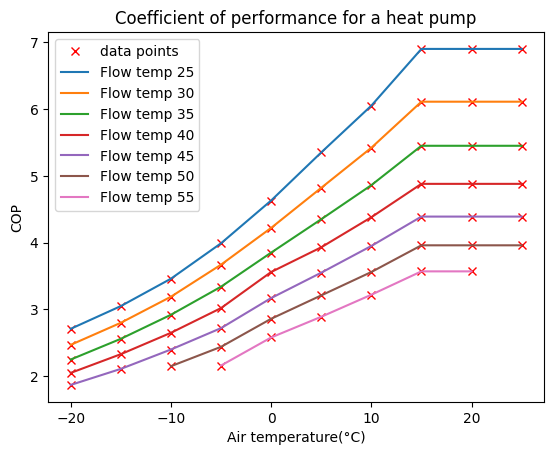

In [11]:
from Modules.Heating import Heat_Pump
import matplotlib.pyplot as plt
import Modules.Data as Data
import numpy as np

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv")

COP_interp = Heat_Pump.interp_init("COP")

# air_temp = np.linspace(-20, 25, 1000)
# hydronics_temp = [25, 30, 35, 40, 45, 47.5, 50, 52.5, 55]

# for flow_temp in hydronics_temp:

#     COP = Heat_Pump.interp_call(flow_temp, air_temp, COP_interp)
    
#     plt.plot(air_temp, COP, label = 'Flow temp ' + str(flow_temp) + '°C')
    
# data points
data_air_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "Air temperature(°C)")

data_flow_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "Flow temperature(°C)") 

data_COP = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv", "COP") 
# data_COP = Heat_Pump.interp_call(data_flow_temp, data_air_temp, COP_interp)

plt.plot(data_air_temp, data_COP, label="data points", marker='x', color='red', linestyle='None')

# creating lines between points
flow_temps = np.unique(data_flow_temp)
for flow_temp in flow_temps:
    indices = [i for i, x in enumerate(data_flow_temp) if x == flow_temp]
    plt.plot(data_air_temp[indices], data_COP[indices], label="Flow temp " + str(flow_temp), linestyle='solid')

plt.title('Coefficient of performance for a heat pump')
plt.xlabel('Air temperature(°C)')
plt.ylabel('COP')
plt.legend()

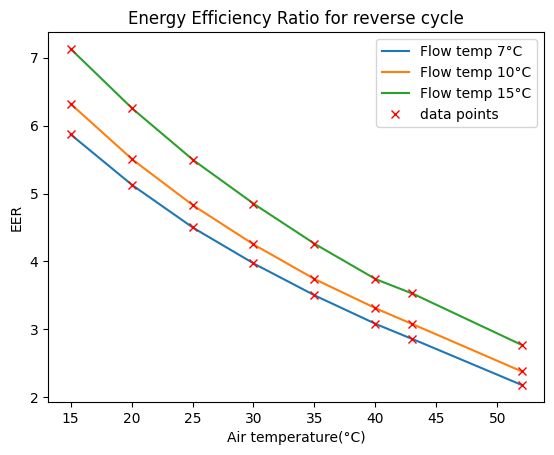

In [12]:
from Modules.Heating import HVAC
import matplotlib.pyplot as plt
import Modules.Data as Data
import numpy as np

HVAC = HVAC("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv")

EER_interp = HVAC.interp_init("EER")

air_temp = np.linspace(15, 52, 1000)
hydronics_temp = [7, 10, 15]

for flow_temp in hydronics_temp:

    EER = HVAC.interp_call(flow_temp, air_temp, EER_interp)
    
    plt.plot(air_temp, EER, label = 'Flow temp ' + str(flow_temp) + '°C')
    
# data points
data_air_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv", "Air temperature(°C)")

data_flow_temp = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv", "Flow temperature(°C)") 

data_EER = Data.column_from_csv("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv", "EER") 
# data_EER = HVAC.interp_call(data_flow_temp, data_air_temp, EER_interp)

plt.plot(data_air_temp, data_EER, label="data points", marker='x', color='red', linestyle='None')

plt.title('Energy Efficiency Ratio for reverse cycle')
plt.xlabel('Air temperature(°C)')
plt.ylabel('EER')
plt.legend()

Number of fan coils required: 64
Total heating electricity usage 110211.44431847244 kWh/yr
Heating provided by HP 333219.97935586306 kWh/yr
Heating provided by EB 8411.670644136924 kWh/yr
Electric Boiler size  92.644 kW
Effective COP: 3.0997838029669977
Total cooling electricity usage 50794.68519678561 kWh/yr
Effective EER: 4.889509188565988


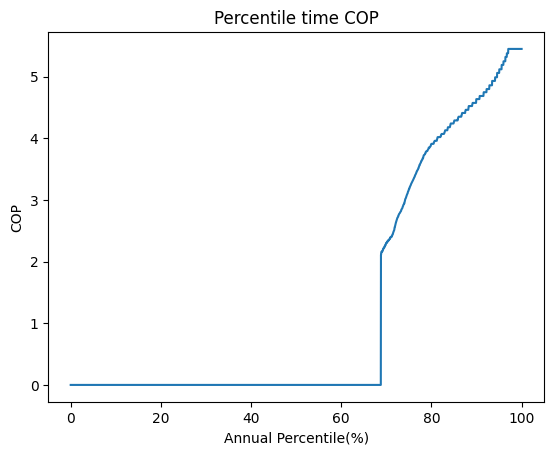

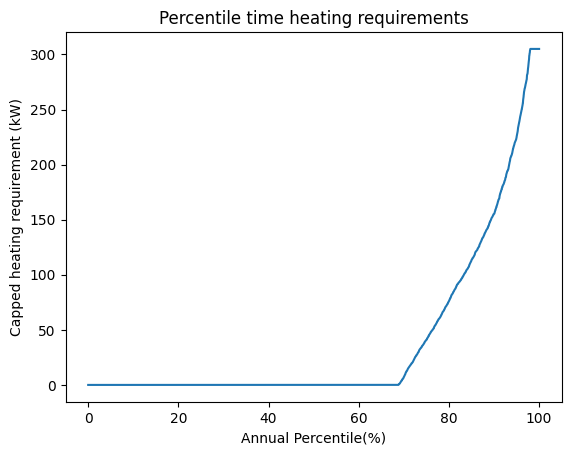

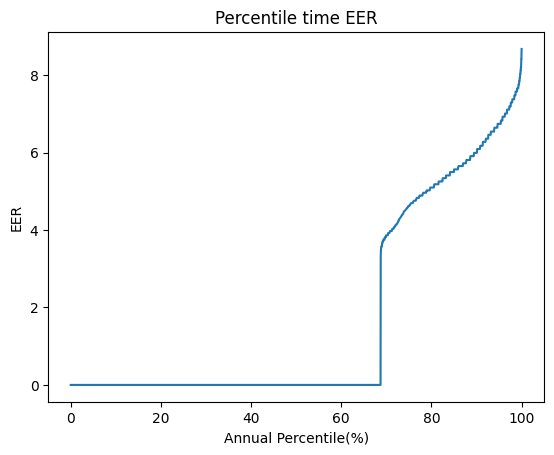

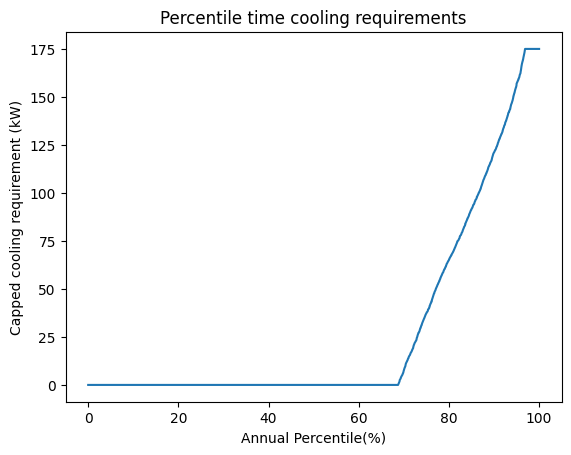

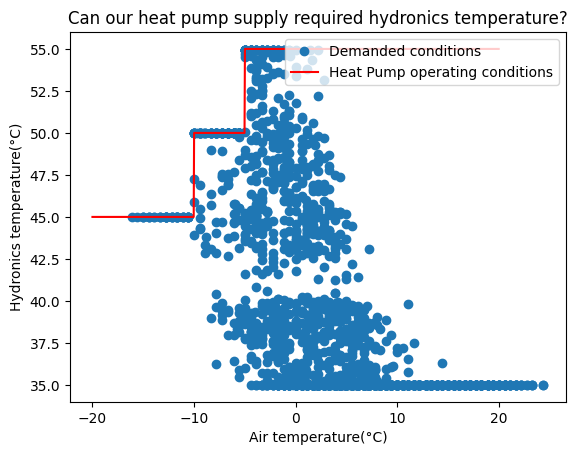

In [13]:
from Modules.Heating import Heat_Pump
from Modules.Heating import HVAC
from Modules.Heating import Reverse_HP_Controller
from Modules.Heating import Heating_Distribution
import numpy as np
import matplotlib.pyplot as plt

# np.set_printoptions(threshold=np.inf)

max_HP_power = 305 # in kW
max_HVAC_power = 175 # in kW
Heat_Pump_count = 2

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv")
HVAC = HVAC("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv")

Heating_Distribution = Heating_Distribution("Data/HFP-550LM-Z1", max_HP_power, max_HVAC_power)

Controller = Reverse_HP_Controller(Heat_Pump, Heat_Pump_count, HVAC, Heating_Distribution, max_HP_power, max_HVAC_power)

(
    time, air_temp,
    heating, heating_electricity,
    heating_hydronics_temp, HP_deliver_temp,
    HP_heating, HP_electricity_demand, COP,
    boiler_power,
    cooling, cooling_electricity, cooling_hydronics_temp, EER
) = Controller.controller()

# HP system
print('Total heating electricity usage ' + str(np.sum(heating_electricity)) + ' kWh/yr')
print('Heating provided by HP ' + str(np.sum(HP_heating)) + ' kWh/yr')
print('Heating provided by EB ' + str(np.sum(boiler_power)) + ' kWh/yr')
print('Electric Boiler size  ' + str(np.max(boiler_power)) + ' kW')

effective_COP = np.sum(heating) / np.sum(heating_electricity)
print('Effective COP: ' + str(effective_COP))

# HVAC system
print('Total cooling electricity usage ' + str(np.sum(cooling_electricity)) + ' kWh/yr')

effective_EER = np.sum(cooling) / np.sum(cooling_electricity)
print('Effective EER: ' + str(effective_EER))

# When heating is zero set COP to 0
indices = [i for i, x in enumerate(heating) if x == 0]
COP[indices] = 0

# When cooling is zero set EER to 0
indices = [i for i, x in enumerate(cooling) if x == 0]
EER[indices] = 0

plt.figure(0)
plt.plot(100 * time / np.max(time), np.sort(COP))
plt.title("Percentile time COP")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('COP')

plt.figure(1)
plt.plot(100 * time / np.max(time), np.sort(heating))
plt.title('Percentile time heating requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped heating requirement (kW)')

plt.figure(2)
plt.plot(100 * time / np.max(time), np.sort(EER))
plt.title("Percentile time EER")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('EER')

plt.figure(3)
plt.plot(100 * time / np.max(time), np.sort(cooling))
plt.title('Percentile time cooling requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped cooling requirement (kW)')

plt.figure(4)
indices = [i for i, x in enumerate(heating) if x != 0]
plt.plot(air_temp[indices], HP_deliver_temp[indices], marker="o", label="Demanded conditions", linestyle="None")
air_temp_op_conditions = np.linspace(-20, 20, 1000)
hydronics_temp_op_conditions = np.ones(len(air_temp_op_conditions)) * 55
hydronics_temp_op_conditions = Heat_Pump.operating_conditions_check(hydronics_temp_op_conditions, air_temp_op_conditions)
plt.plot(air_temp_op_conditions, hydronics_temp_op_conditions, color="red", label="Heat Pump operating conditions")
plt.xlabel("Air temperature(°C)")
plt.ylabel("Hydronics temperature(°C)")
plt.title("Can our heat pump supply required hydronics temperature?")
plt.legend(loc='upper right')

# Constant Temperature Hydronics System

Total heating electricity usage 136439.07195363755 kWh/yr
Heating provided by HP 333091.482 kWh/yr
Heating provided by EB 8540.167999999998 kWh/yr
Electric Boiler size  92.644 kW
Effective COP: 2.503913615859888
Total cooling electricity usage 55754.93439713156 kWh/yr
Effective EER: 4.454512998454492


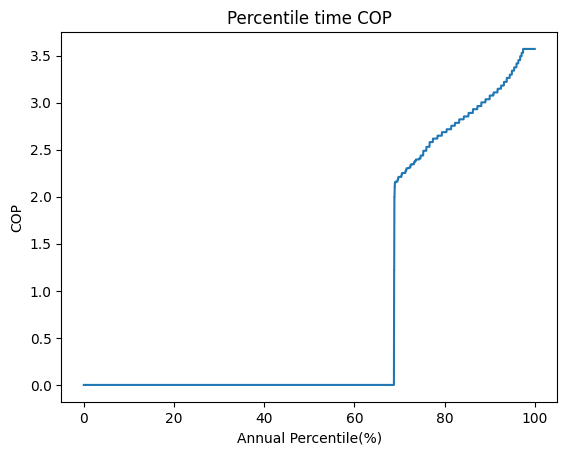

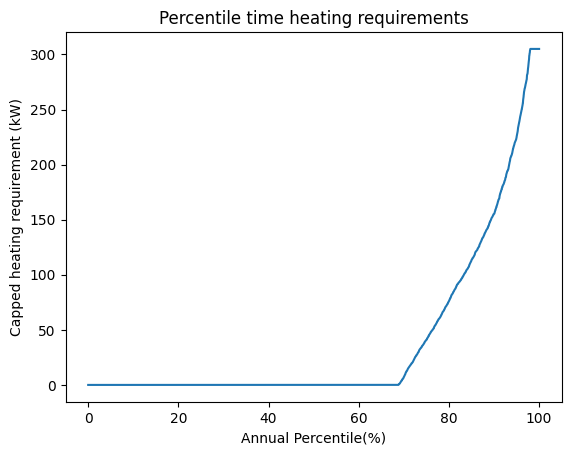

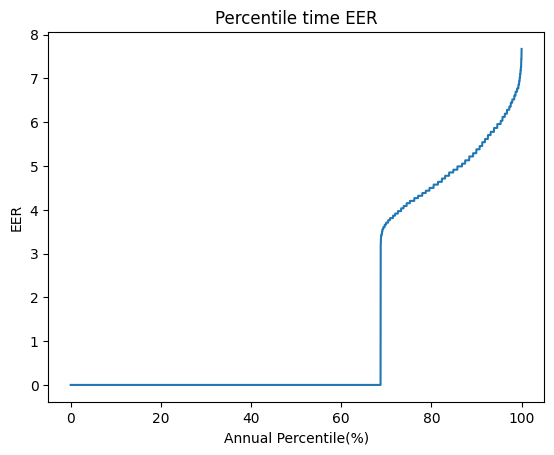

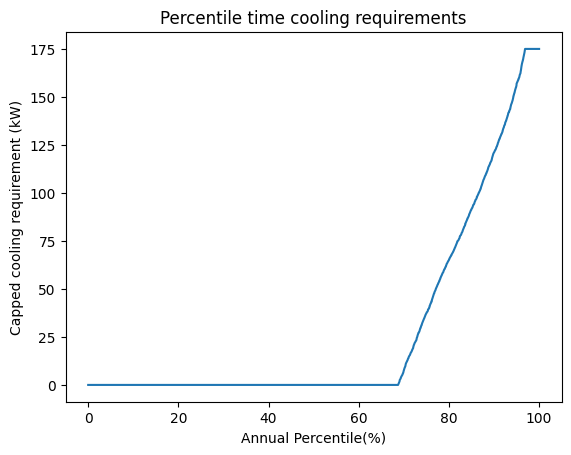

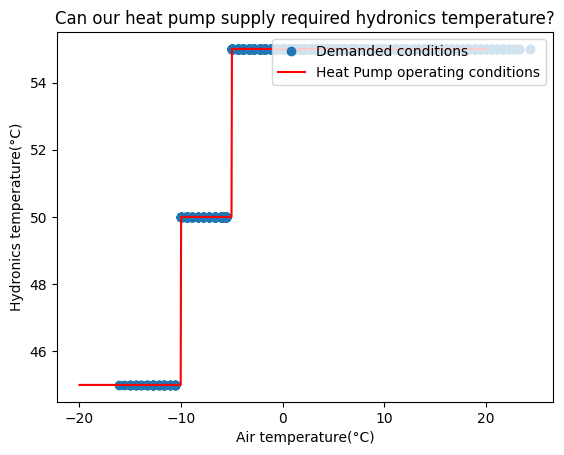

In [14]:
from Modules.Heating import Heat_Pump
from Modules.Heating import HVAC
from Modules.Heating import Reverse_HP_Controller
from Modules.Heating import Const_Temp_Heating_Distribution as Heating_Distribution
import numpy as np
import matplotlib.pyplot as plt

max_HP_power = 305 # in kW
max_HVAC_power = 175 # in kW
Heat_Pump_count = 2
heating_hydronics_temp = 55
cooling_hydronics_temp = 7

Heat_Pump = Heat_Pump("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Heating_10C.csv")
HVAC = HVAC("Data/Heat_Pump/EAHV-M1500-YCL(-N)/Cooling_10C.csv")

Heating_Distribution = Heating_Distribution(heating_hydronics_temp, cooling_hydronics_temp)

Controller = Reverse_HP_Controller(Heat_Pump, Heat_Pump_count, HVAC, Heating_Distribution, max_HP_power, max_HVAC_power)

(
    time, air_temp,
    heating, heating_electricity,
    heating_hydronics_temp, HP_deliver_temp,
    HP_heating, HP_electricity_demand, COP,
    boiler_power,
    cooling, cooling_electricity, cooling_hydronics_temp, EER
) = Controller.controller()

# HP system
print('Total heating electricity usage ' + str(np.sum(heating_electricity)) + ' kWh/yr')
print('Heating provided by HP ' + str(np.sum(HP_heating)) + ' kWh/yr')
print('Heating provided by EB ' + str(np.sum(boiler_power)) + ' kWh/yr')
print('Electric Boiler size  ' + str(np.max(boiler_power)) + ' kW')

effective_COP = np.sum(heating) / np.sum(heating_electricity)
print('Effective COP: ' + str(effective_COP))

# HVAC system
print('Total cooling electricity usage ' + str(np.sum(cooling_electricity)) + ' kWh/yr')

effective_EER = np.sum(cooling) / np.sum(cooling_electricity)
print('Effective EER: ' + str(effective_EER))

# When heating is zero set COP to 0
indices = [i for i, x in enumerate(heating) if x == 0]
COP[indices] = 0

# When cooling is zero set EER to 0
indices = [i for i, x in enumerate(cooling) if x == 0]
EER[indices] = 0

plt.figure(0)
plt.plot(100 * time / np.max(time), np.sort(COP))
plt.title("Percentile time COP")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('COP')

plt.figure(1)
plt.plot(100 * time / np.max(time), np.sort(heating))
plt.title('Percentile time heating requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped heating requirement (kW)')

plt.figure(2)
plt.plot(100 * time / np.max(time), np.sort(EER))
plt.title("Percentile time EER")
plt.xlabel('Annual Percentile(%)')
plt.ylabel('EER')

plt.figure(3)
plt.plot(100 * time / np.max(time), np.sort(cooling))
plt.title('Percentile time cooling requirements')
plt.xlabel('Annual Percentile(%)')
plt.ylabel('Capped cooling requirement (kW)')

plt.figure(4)
indices = [i for i, x in enumerate(heating) if x != 0]
plt.plot(air_temp[indices], HP_deliver_temp[indices], marker="o", label="Demanded conditions", linestyle="None")
air_temp_op_conditions = np.linspace(-20, 20, 1000)
hydronics_temp_op_conditions = np.ones(len(air_temp_op_conditions)) * 55
hydronics_temp_op_conditions = Heat_Pump.operating_conditions_check(hydronics_temp_op_conditions, air_temp_op_conditions)
plt.plot(air_temp_op_conditions, hydronics_temp_op_conditions, color="red", label="Heat Pump operating conditions")
plt.xlabel("Air temperature(°C)")
plt.ylabel("Hydronics temperature(°C)")
plt.title("Can our heat pump supply required hydronics temperature?")
plt.legend(loc='upper right')
